In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error

In [3]:
#pip install xgboost

In [ ]:
import dagshub
import mlflow

dagshub.init(
    repo_owner='Sandhya234-wq', 
    repo_name='Flight-Price-Prediction', 
    mlflow=True
)



mlflow.set_tracking_uri('https://dagshub.com/Sandhya234-wq/Flight-Price-Prediction.mlflow')

mlflow.set_experiment("Flight_Price_Prediction")


Accessing as Sandhya234-wq

Initialized MLflow to track repo "Sandhya234-wq/Flight-Price-Prediction"

Repository Sandhya234-wq/Flight-Price-Prediction initialized!

<Experiment: artifact_location='mlflow-artifacts:/f2a87b2704e7473c98bce6794fdec9de', creation_time=1751670804951, experiment_id='0', last_update_time=1751670804951, lifecycle_stage='active', name='Flight_Price_Prediction', tags={}>

In [5]:
dataset = pd.read_csv(r'G:\GitDemo\Flight_ML_Project\Flight_Price.csv')

In [6]:
dataset.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [8]:
dataset['Journey_day'] = pd.to_datetime(dataset['Date_of_Journey'], format="%d/%m/%Y").dt.day
dataset['Journey_month'] = pd.to_datetime(dataset['Date_of_Journey'], format="%d/%m/%Y").dt.month
dataset.drop(['Date_of_Journey'], axis=1, inplace=True)


In [9]:
# Departure Time
dataset['Dep_hour'] = pd.to_datetime(dataset['Dep_Time']).dt.hour
dataset['Dep_minute'] = pd.to_datetime(dataset['Dep_Time']).dt.minute


C:\Users\hp\AppData\Local\Temp\ipykernel_15072\276504002.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['Dep_hour'] = pd.to_datetime(dataset['Dep_Time']).dt.hour
C:\Users\hp\AppData\Local\Temp\ipykernel_15072\276504002.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['Dep_minute'] = pd.to_datetime(dataset['Dep_Time']).dt.minute


In [10]:
dataset.drop(['Dep_Time'], axis=1, inplace=True)

In [11]:
# Arrival Time (handle date suffix)
dataset['Arrival_Time'] = dataset['Arrival_Time'].str.split().str[0]  # Remove date part
dataset['Arrival_hour'] = pd.to_datetime(dataset['Arrival_Time']).dt.hour
dataset['Arrival_minute'] = pd.to_datetime(dataset['Arrival_Time']).dt.minute


C:\Users\hp\AppData\Local\Temp\ipykernel_15072\1836629200.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['Arrival_hour'] = pd.to_datetime(dataset['Arrival_Time']).dt.hour
C:\Users\hp\AppData\Local\Temp\ipykernel_15072\1836629200.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['Arrival_minute'] = pd.to_datetime(dataset['Arrival_Time']).dt.minute


In [12]:
dataset.drop(['Arrival_Time'], axis=1, inplace=True)

In [13]:
# Fill missing 'm' or 'h'
dataset['Duration'] = dataset['Duration'].apply(lambda x: x if 'h' in x else '0h ' + x)
dataset['Duration'] = dataset['Duration'].apply(lambda x: x if 'm' in x else x + ' 0m')

In [14]:
# Extract hours and minutes
dataset['Duration_hours'] = dataset['Duration'].apply(lambda x: int(x.split('h')[0]))
dataset['Duration_minutes'] = dataset['Duration'].apply(lambda x: int(x.split('h')[1].split('m')[0].strip()))


In [15]:
dataset.drop(['Duration'], axis=1, inplace=True)

In [16]:
stops_map = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}
dataset['Total_Stops'] = dataset['Total_Stops'].map(stops_map)


In [17]:
dataset.drop(['Route', 'Additional_Info'], axis=1, inplace=True)


In [18]:
dataset.isnull().sum()

Airline             0
Source              0
Destination         0
Total_Stops         1
Price               0
Journey_day         0
Journey_month       0
Dep_hour            0
Dep_minute          0
Arrival_hour        0
Arrival_minute      0
Duration_hours      0
Duration_minutes    0
dtype: int64

In [19]:
dataset.dropna(inplace=True)

In [20]:
dataset.duplicated().sum()

np.int64(222)

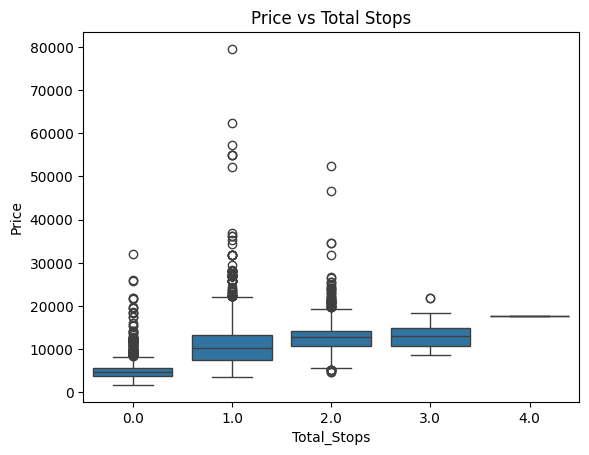

In [21]:
 #EDA Visualizations
sns.boxplot(data=dataset, x='Total_Stops', y='Price')
plt.title("Price vs Total Stops")
plt.show()


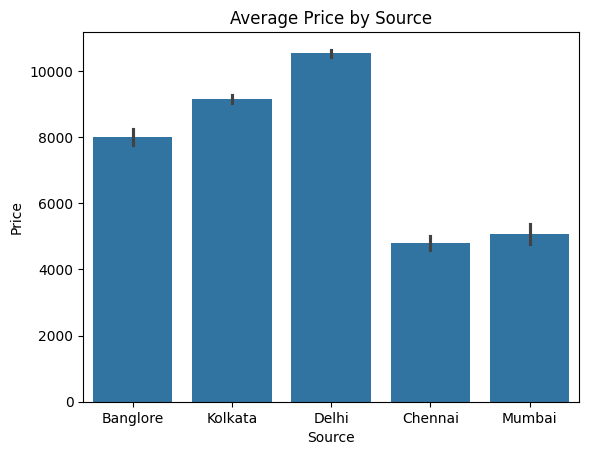

In [22]:
sns.barplot(data=dataset, x='Source', y='Price', estimator=np.mean)
plt.title("Average Price by Source")
plt.show()

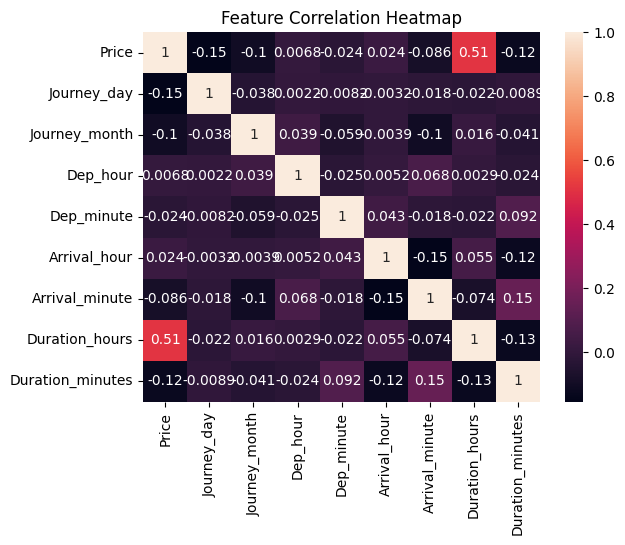

In [23]:
sns.heatmap(dataset[['Price', 'Journey_day', 'Journey_month', 'Dep_hour', 'Dep_minute',
                'Arrival_hour', 'Arrival_minute', 'Duration_hours', 'Duration_minutes']].corr(), annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

In [24]:
import os
os.makedirs("plots", exist_ok=True)

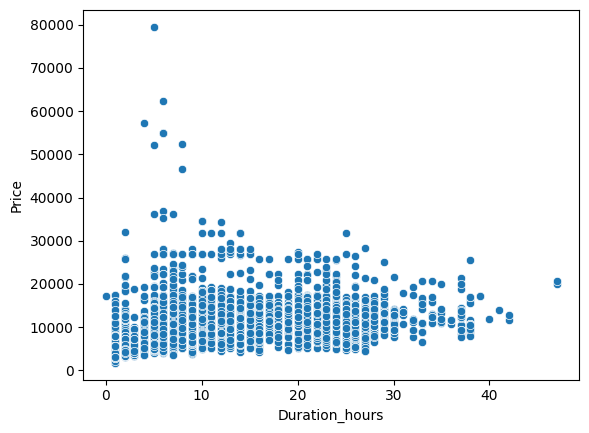

In [25]:
sns.scatterplot(x='Duration_hours', y='Price', data=dataset)
plt.show()

In [26]:
plot_definitions = {
    "price_vs_total_stops": lambda: sns.boxplot(x='Total_Stops', y='Price', data=dataset),
    "avg_price_by_source": lambda: sns.barplot(x='Source', y='Price', data=dataset, estimator=np.mean),
    "duration_vs_price": lambda: sns.scatterplot(x='Duration_hours', y='Price', data=dataset),
    "correlation_heatmap": lambda: sns.heatmap(dataset[['Price', 'Journey_day', 'Journey_month', 'Dep_hour',
                              'Dep_minute', 'Arrival_hour', 'Arrival_minute',
                            'Duration_hours', 'Duration_minutes']].corr(), annot=True, cmap='coolwarm')
}

In [27]:

os.makedirs("plots2", exist_ok=True)

In [28]:
for plot_name, plot_func in plot_definitions.items():
    plt.figure(figsize=(8, 5))
    plot_func()
    plt.title(plot_name.replace("_", " ").title())
    
    file_path = f"plots/{plot_name}.png"
    plt.savefig(file_path)
    plt.close()

In [29]:
plot_path = "G:\GitDemo\Flight_ML_Project\plots"
plt.savefig(plot_path)
plt.close()


<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\hp\AppData\Local\Temp\ipykernel_15072\3292888899.py:1: SyntaxWarning: invalid escape sequence '\G'
  plot_path = "G:\GitDemo\Flight_ML_Project\plots"


In [30]:
#  Feature & Target Split

In [31]:
x = dataset.drop('Price', axis=1)
y = dataset['Price']

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [33]:
# Features
num_features = ['Journey_day', 'Journey_month', 'Dep_hour', 'Dep_minute',
                'Arrival_hour', 'Arrival_minute', 'Duration_hours', 'Duration_minutes', 'Total_Stops']

cat_features = ['Airline', 'Source', 'Destination']

In [34]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
])


In [35]:
from sklearn.pipeline import Pipeline

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

In [37]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}


In [38]:
#  MLflow Tracking


In [39]:
import mlflow
import mlflow.sklearn

In [40]:
mlflow.set_experiment("Flight_Price_Regression_EDA")

<Experiment: artifact_location='mlflow-artifacts:/b8f5495b29ff448e9a6da53dab2d88ad', creation_time=1751701427808, experiment_id='1', last_update_time=1751701427808, lifecycle_stage='active', name='Flight_Price_Regression_EDA', tags={}>

In [42]:
with mlflow.start_run(run_name="EDA_Plots"):
    for plot_name, plot_func in plot_definitions.items():
        plt.figure(figsize=(8, 5))
        plot_func()
        plt.title(plot_name.replace("_", " ").title())

        # Save the plot
        file_path = f"plots/{plot_name}.png"
        plt.savefig('G:\GitDemo\Flight_ML_Project\plots2.png')
        plt.close()


        mlflow.log_artifact(file_path, artifact_path="EDA_Plots")

<>:9: SyntaxWarning: invalid escape sequence '\G'
<>:9: SyntaxWarning: invalid escape sequence '\G'
C:\Users\hp\AppData\Local\Temp\ipykernel_15072\3347229786.py:9: SyntaxWarning: invalid escape sequence '\G'
  plt.savefig('G:\GitDemo\Flight_ML_Project\plots2.png')


🏃 View run EDA_Plots at: https://dagshub.com/Sandhya234-wq/Flight-Price-Prediction.mlflow/#/experiments/1/runs/c62f79197631412a97fbba8ad831a295
🧪 View experiment at: https://dagshub.com/Sandhya234-wq/Flight-Price-Prediction.mlflow/#/experiments/1


In [43]:
import joblib

In [44]:
for flight, model in models.items():
    with mlflow.start_run(run_name=flight):
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])

        pipeline.fit(x_train, y_train)
        y_pred = pipeline.predict(x_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mlflow.log_param("model", flight)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2_Score", r2)

        mlflow.log_artifact(plot_path)
        
    


       # mlflow.sklearn.log_model(pipeline, "model")


        print(f"{flight} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

LinearRegression - MAE: 1972.94, RMSE: 8202327.56, R2: 0.62
🏃 View run LinearRegression at: https://dagshub.com/Sandhya234-wq/Flight-Price-Prediction.mlflow/#/experiments/1/runs/546c1132ec9048dca8d526ef68c0b65b
🧪 View experiment at: https://dagshub.com/Sandhya234-wq/Flight-Price-Prediction.mlflow/#/experiments/1
RandomForest - MAE: 1179.76, RMSE: 4386013.24, R2: 0.80
🏃 View run RandomForest at: https://dagshub.com/Sandhya234-wq/Flight-Price-Prediction.mlflow/#/experiments/1/runs/0c8a33f8785148baba72bc922484e7d3
🧪 View experiment at: https://dagshub.com/Sandhya234-wq/Flight-Price-Prediction.mlflow/#/experiments/1
XGBoost - MAE: 1242.93, RMSE: 3464289.50, R2: 0.84
🏃 View run XGBoost at: https://dagshub.com/Sandhya234-wq/Flight-Price-Prediction.mlflow/#/experiments/1/runs/97d66db213bd400eaa472c209aff8be0
🧪 View experiment at: https://dagshub.com/Sandhya234-wq/Flight-Price-Prediction.mlflow/#/experiments/1


In [ ]:
joblib.dump(pipeline, "flight_price_model.pkl")


['flight_price_model.pkl']